In [3]:
import pandas as pd
import numpy as np
import time
import random
from pytrends.request import TrendReq
from datetime import datetime, timedelta

pytrends = TrendReq(hl='en-US', tz=360)

# Time range
start_date = datetime(2010,1,1)
end_date = datetime(2025,4,16)

# keywords
positive_keywords = ["Pfizer vaccine", "Pfizer approval", "Pfizer success", "Pfizer breakthrough"]
negative_keywords = ["Pfizer side effects", "Pfizer lawsuit", "Pfizer recall", "Pfizer failure"]

all_data = pd.DataFrame()

def fetch_trend(keyword, start, end):
    retries = 3
    for _ in range(retries):
        try:
            pytrends.build_payload([keyword], timeframe=f"{start} {end}")
            df = pytrends.interest_over_time()
            if df.empty or keyword not in df.columns:
                return None
            return df[[keyword]]
        except Exception as e:
            if "429" in str(e):
                sleep_time = random.uniform(60, 120)
                print(f"Rate limit hit. Sleeping for {sleep_time:.1f} seconds...")
                time.sleep(sleep_time)
            else:
                print(f"Error fetching '{keyword}' for {start} - {end}: {e}")
                return None
    return None

current = start_date
batch_size = timedelta(days=30)

try:
    while current < end_date:
        batch_end = min(current + batch_size, end_date)
        print(f"Processing {current.date()} to {batch_end.date()}...")

        pos_score, neg_score = None, None

        # Positive
        for kw in positive_keywords:
            df = fetch_trend(kw, current.strftime('%Y-%m-%d'), batch_end.strftime('%Y-%m-%d'))
            if df is not None:
                pos_score = df if pos_score is None else pos_score.add(df, fill_value=0)
            time.sleep(random.uniform(3, 6))

        # Negative
        for kw in negative_keywords:
            df = fetch_trend(kw, current.strftime('%Y-%m-%d'), batch_end.strftime('%Y-%m-%d'))
            if df is not None:
                neg_score = df if neg_score is None else neg_score.add(df, fill_value=0)
            time.sleep(random.uniform(3, 6))

        # Skip if no data
        if pos_score is None and neg_score is None:
            current = batch_end
            continue

        idx = pos_score.index if pos_score is not None else neg_score.index

        result = pd.DataFrame(index=idx)
        result["positive_score"] = pos_score.sum(axis=1) if pos_score is not None else 0
        result["negative_score"] = neg_score.sum(axis=1) if neg_score is not None else 0
        result["sentiment_score"] = result["positive_score"] - result["negative_score"]

        def classify(score):
            if score > 5:
                return "Positive"
            elif score < -5:
                return "Negative"
            else:
                return "Neutral"

        result["sentiment_label"] = result["sentiment_score"].apply(classify)

        all_data = pd.concat([all_data, result])
        all_data.reset_index().to_csv("pfizer_sentiment_partial.csv", index=False)
        print(f"✅ Saved partial data up to {batch_end.date()}")

        current = batch_end

    # Final Save
    all_data.reset_index().to_csv("pfizer_sentiment_from_google_trends_full.csv", index=False)
    print("✅ Final sentiment data saved to 'pfizer_sentiment_from_google_trends_full.csv'")

except Exception as e:
    print(f"⚠️ Script failed with error: {e}")
    all_data.reset_index().to_csv("pfizer_sentiment_partial.csv", index=False)
    print("💾 Partial data saved as 'pfizer_sentiment_partial.csv'")

Processing 2016-05-30 to 2016-06-29...
Processing 2016-06-29 to 2016-07-29...
✅ Saved partial data up to 2016-07-29
Processing 2016-07-29 to 2016-08-28...
Rate limit hit. Sleeping for 114.4 seconds...
✅ Saved partial data up to 2016-08-28
Processing 2016-08-28 to 2016-09-27...
Rate limit hit. Sleeping for 102.9 seconds...
Rate limit hit. Sleeping for 76.3 seconds...
Processing 2016-09-27 to 2016-10-27...
✅ Saved partial data up to 2016-10-27
Processing 2016-10-27 to 2016-11-26...
Rate limit hit. Sleeping for 66.9 seconds...
Rate limit hit. Sleeping for 89.9 seconds...
Rate limit hit. Sleeping for 117.6 seconds...
Processing 2016-11-26 to 2016-12-26...
Rate limit hit. Sleeping for 63.9 seconds...
Rate limit hit. Sleeping for 108.2 seconds...
Rate limit hit. Sleeping for 117.3 seconds...
✅ Saved partial data up to 2016-12-26
Processing 2016-12-26 to 2017-01-25...
✅ Saved partial data up to 2017-01-25
Processing 2017-01-25 to 2017-02-24...
✅ Saved partial data up to 2017-02-24
Processing 

In [28]:
import pandas as pd

pfe = pd.read_csv('Pfizer Stock Price History.csv')
xlv = pd.read_csv('XLV ETF Stock Price History.csv')
sentiment = pd.read_csv('sentiment_google_trends.csv')

# --- Data Cleaning ---

pfe['Date'] = pfe['Date'].str.replace('-', '/')
xlv['Date'] = xlv['Date'].str.strip()
xlv['Date'] = xlv['Date'].str.replace('-', '/') 

pfe['Date'] = pd.to_datetime(pfe['Date'], format='%m/%d/%Y', errors='raise')
xlv['Date'] = pd.to_datetime(xlv['Date'], format='%m/%d/%Y', errors='raise')
sentiment['Date'] = pd.to_datetime(sentiment['Date'], format='%d-%m-%Y', errors='raise')

pfe.sort_values('Date', inplace=True)
xlv.sort_values('Date', inplace=True)
sentiment.sort_values('Date', inplace=True)

df = pfe[['Date', 'Price', 'Vol.']].merge(
    xlv[['Date', 'Price']], on='Date', suffixes=('_pfe', '_xlv'))

df = df.merge(sentiment[['Date', 'sentiment_score', 'sentiment_label']], on='Date', how='left')

df['sentiment_score'].fillna(method='ffill', inplace=True)
df['sentiment_label'].fillna(0, inplace=True)  # Neutral label

def convert_volume_str(vol_str):
    vol_str = vol_str.strip().upper().replace(',', '')  # Clean spaces & commas
    if vol_str.endswith('M'):
        return float(vol_str[:-1]) * 1_000_000
    elif vol_str.endswith('K'):
        return float(vol_str[:-1]) * 1_000
    else:
        return float(vol_str)

df['Vol.'] = df['Vol.'].astype(str).apply(convert_volume_str)

# --- Feature Engineering ---

# 1. Price & Volume Technical Features
df['return_1d'] = df['Price_pfe'].pct_change(1)
df['return_5d'] = df['Price_pfe'].pct_change(5)
df['return_20d'] = df['Price_pfe'].pct_change(20)

df['volatility_20d'] = df['return_1d'].rolling(window=20, min_periods=15).std()
df['rolling_mean_20d'] = df['Price_pfe'].rolling(window=20, min_periods=15).mean()
df['rolling_std_20d'] = df['Price_pfe'].rolling(window=20, min_periods=15).std()
df['zscore_price_20d'] = (df['Price_pfe'] - df['rolling_mean_20d']) / df['rolling_std_20d']
df['price_pct_change'] = df['Price_pfe'].pct_change(1)

vol_mean = df['Vol.'].rolling(window=20, min_periods=15).mean()
vol_std = df['Vol.'].rolling(window=20, min_periods=15).std()
df['volume_zscore_20d'] = (df['Vol.'] - vol_mean) / vol_std

delta = df['Price_pfe'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(window=14, min_periods=10).mean()
avg_loss = loss.rolling(window=14, min_periods=10).mean()
rs = avg_gain / avg_loss
df['rsi_14'] = 100 - (100 / (1 + rs))

# 2. Sentiment Features
df['rolling_sentiment_5d'] = df['sentiment_score'].rolling(window=5, min_periods=3).mean()
df['sentiment_shift'] = df['sentiment_score'] - df['sentiment_score'].shift(1)
df['sentiment_volatility_5d'] = df['sentiment_score'].rolling(window=5, min_periods=3).std()

# 3. Market Context (XLV)
df['xlv_return_1d'] = df['Price_xlv'].pct_change(1)
df['xlv_return_5d'] = df['Price_xlv'].pct_change(5)
df['pfe_vs_xlv_spread'] = df['return_1d'] - df['xlv_return_1d']

# 4. Rolling Correlation & Lag Features
df['rolling_corr_pfe_xlv_20d'] = df['return_1d'].rolling(window=20, min_periods=15).corr(df['xlv_return_1d'])
df['lag_1_price'] = df['Price_pfe'].shift(1)
df['lag_2_price'] = df['Price_pfe'].shift(2)
df['lag_1_sentiment'] = df['sentiment_score'].shift(1)
df['lag_2_sentiment'] = df['sentiment_score'].shift(2)

# 5. Interaction Features
df['sentiment_non_neutral'] = (df['sentiment_score'] != 0).astype(int)
df['interaction_sentiment_non_neutral_return_5d'] = df['sentiment_non_neutral'] * df['return_5d']
df['interaction_sentiment_volatility'] = df['sentiment_score'] * df['volatility_20d']

df_final = df.dropna().reset_index(drop=True)

# Overall selected features
master_features = [
    'Date', 'return_1d', 'return_5d', 'return_20d', 'volatility_20d', 'rolling_mean_20d',
    'rolling_std_20d', 'zscore_price_20d', 'price_pct_change', 'volume_zscore_20d', 'rsi_14',
    'sentiment_score', 'sentiment_label', 'rolling_sentiment_5d', 'sentiment_shift',
    'sentiment_volatility_5d', 'xlv_return_1d', 'xlv_return_5d', 'pfe_vs_xlv_spread',
    'rolling_corr_pfe_xlv_20d', 'lag_1_price', 'lag_2_price', 'lag_1_sentiment', 'lag_2_sentiment',
    'interaction_sentiment_non_neutral_return_5d', 'interaction_sentiment_volatility'
]

master_df = df_final[master_features]

master_df.to_csv('Pfizer_Feature_Engineering_Master.csv', index=False)

print("✅ Feature engineering complete. Saved to 'Pfizer_Feature_Engineering_Master.csv'.")

# PS: A 'Modeling' column with values 'Train', 'Validation' and 'Out-of-Sample' was added using excel features, in the above generated .csv

✅ Feature engineering complete. Saved to 'Pfizer_Feature_Engineering_Master.csv'.


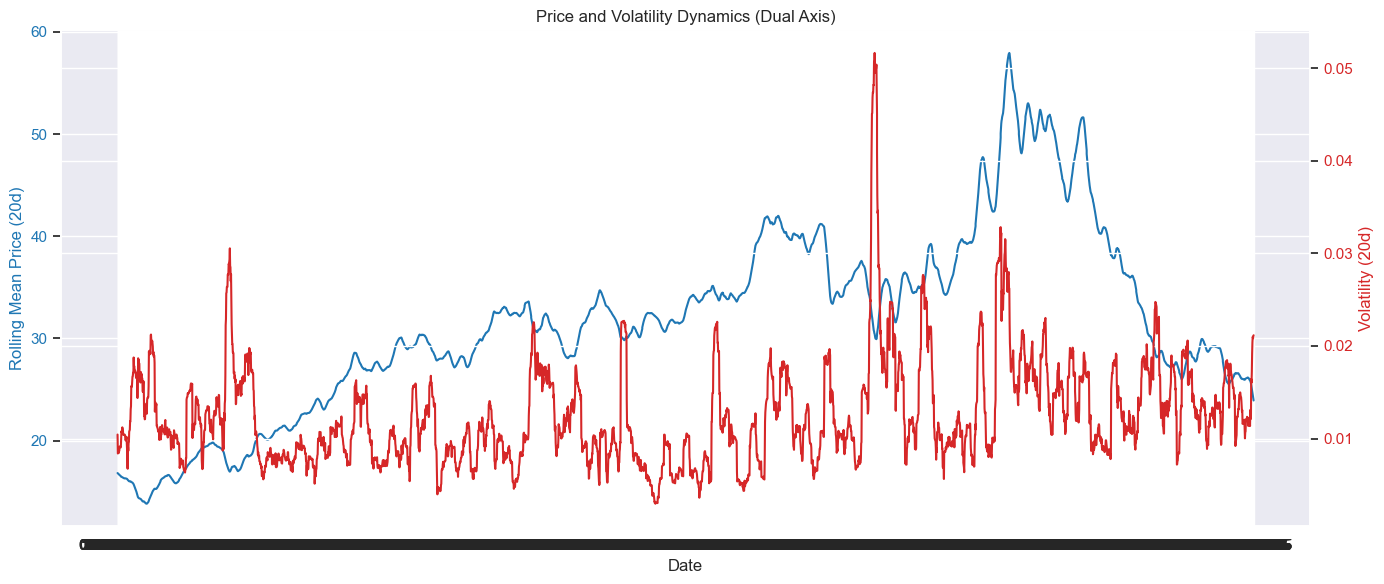

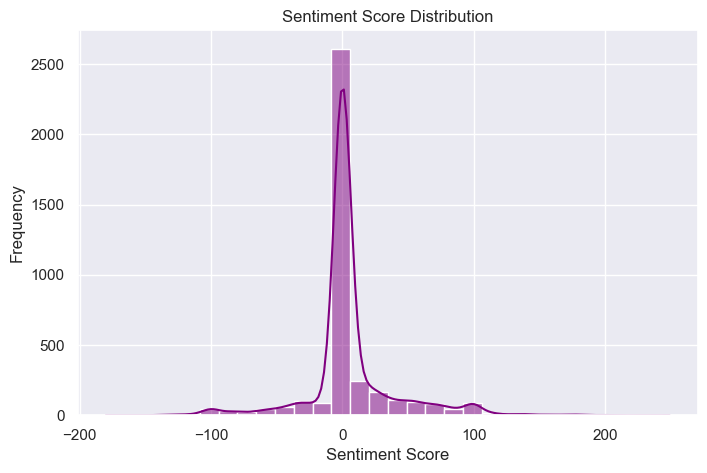

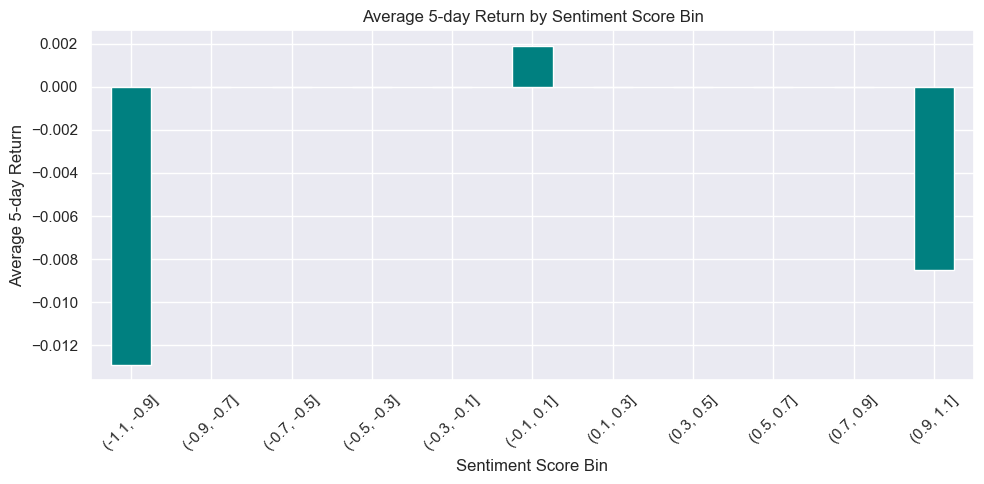

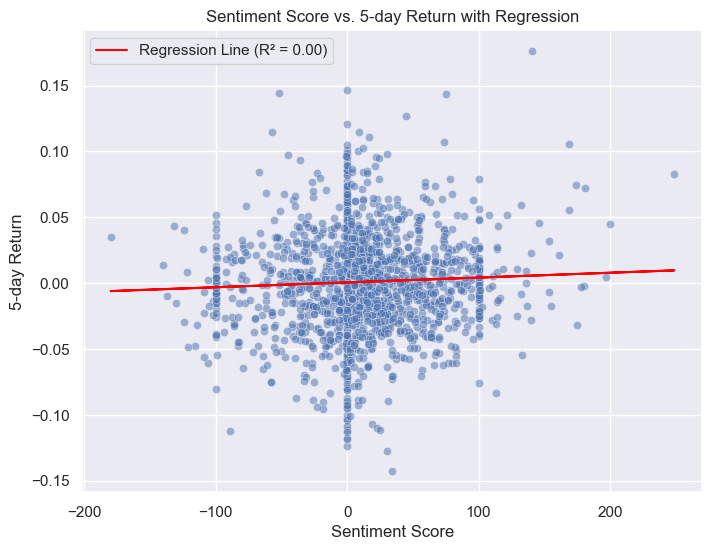

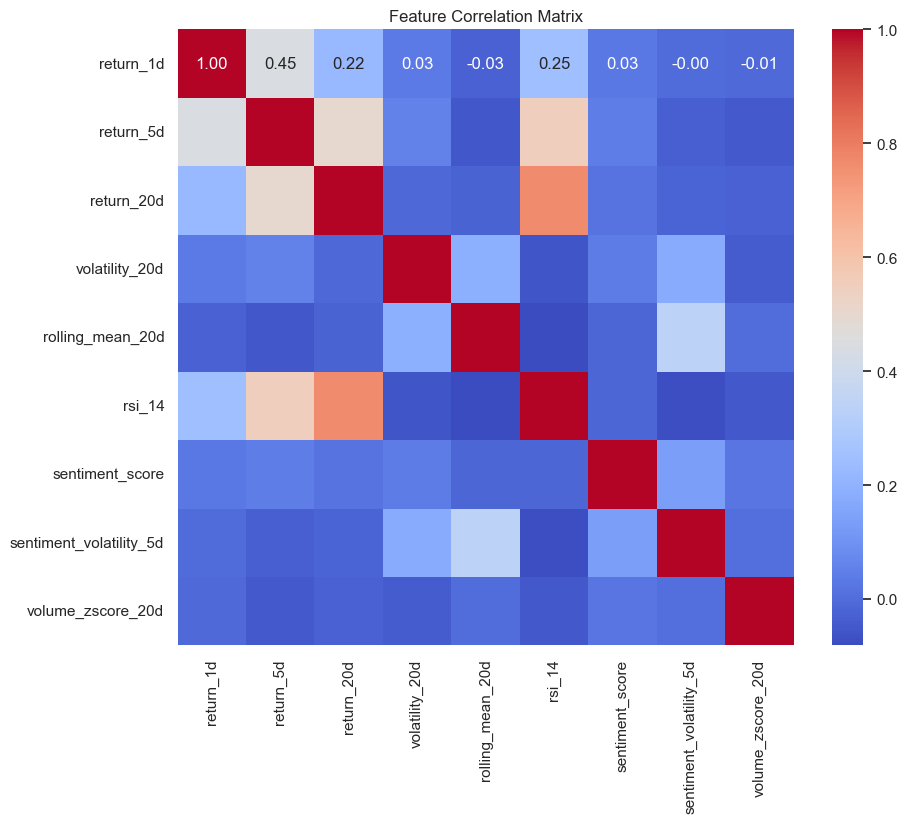

In [29]:
# --- Visualizing the Selected Features ---

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

sns.set_theme(style="darkgrid")

df = pd.read_csv('Pfizer_Feature_Engineering_Master.csv', parse_dates=['Date'])

# 1. Price vs. Volatility Plot
fig, ax1 = plt.subplots(figsize=(14,6))

color1 = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Rolling Mean Price (20d)', color=color1)
ax1.plot(df['Date'], df['rolling_mean_20d'], color=color1, label='Rolling Mean Price (20d)')
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Volatility (20d)', color=color2)
ax2.plot(df['Date'], df['volatility_20d'], color=color2, label='Volatility (20d)')
ax2.tick_params(axis='y', labelcolor=color2)

plt.title('Price and Volatility Dynamics (Dual Axis)')
fig.tight_layout()
plt.show()

# 2. Sentiment distribution
plt.figure(figsize=(8,5))
sns.histplot(df['sentiment_score'].dropna(), kde=True, bins=30, color='purple')
plt.title('Sentiment Score Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

# 3. Sentiment vs. 5-day Return
df_binned = df[['sentiment_score', 'return_5d']].dropna()
df_binned['sentiment_bin'] = pd.cut(df_binned['sentiment_score'], bins=np.arange(-1.1, 1.2, 0.2))
grouped = df_binned.groupby('sentiment_bin')['return_5d'].mean()

plt.figure(figsize=(10,5))
grouped.plot(kind='bar', color='teal')
plt.title('Average 5-day Return by Sentiment Score Bin')
plt.xlabel('Sentiment Score Bin')
plt.ylabel('Average 5-day Return')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

df_reg = df[['sentiment_score', 'return_5d']].dropna()
X = df_reg['sentiment_score'].values.reshape(-1, 1)
y = df_reg['return_5d'].values

model = LinearRegression().fit(X, y)
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X.flatten(), y=y, alpha=0.5)
plt.plot(X, y_pred, color='red', label=f'Regression Line (R² = {r2:.2f})')
plt.title('Sentiment Score vs. 5-day Return with Regression')
plt.xlabel('Sentiment Score')
plt.ylabel('5-day Return')
plt.legend()
plt.show()

# 4. Correlation overview of selected features
features = [
    'return_1d', 'return_5d', 'return_20d',
    'volatility_20d', 'rolling_mean_20d', 'rsi_14',
    'sentiment_score', 'sentiment_volatility_5d',
    'volume_zscore_20d'
]

plt.figure(figsize=(10,8))
corr = df[features].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Feature Correlation Matrix')
plt.show()

Explained Variance Ratio by PCA components:
[0.20485547 0.1735136  0.1052493  0.0822968  0.06575339]
Selected VAR Lag Order: 5
RMSE of return_1d prediction: 0.015325


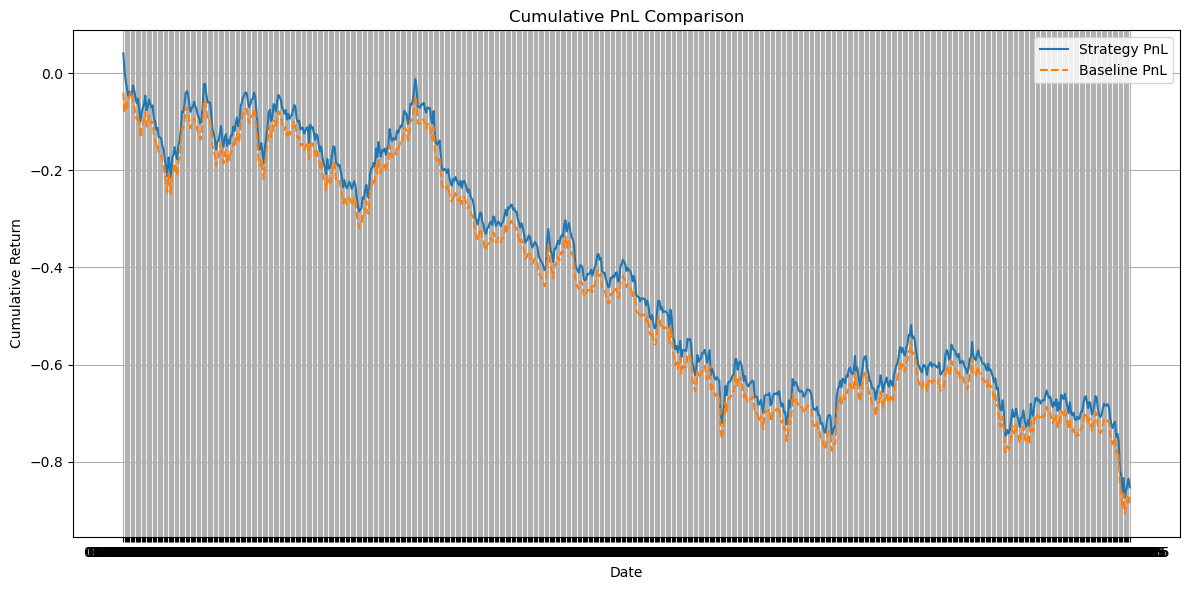

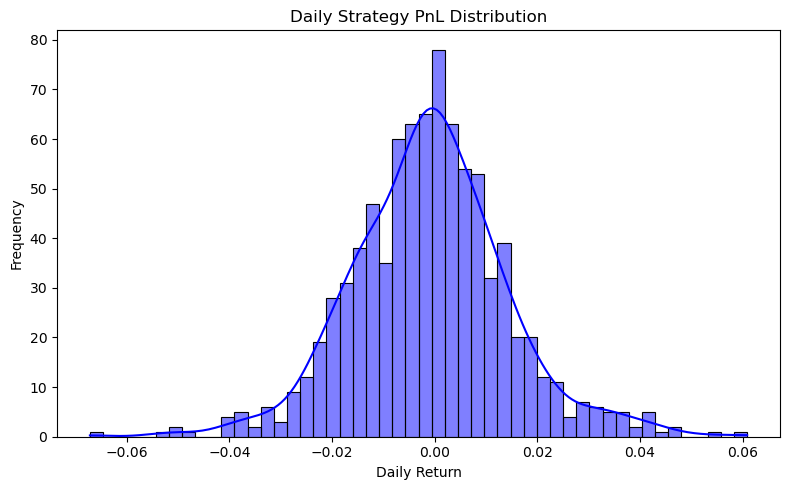

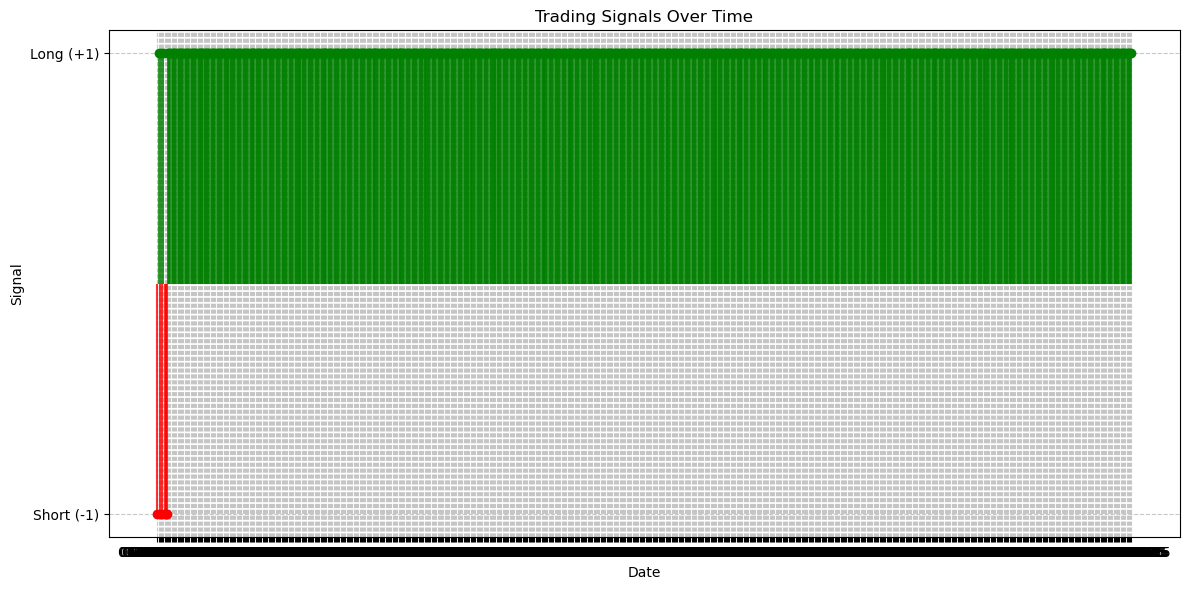

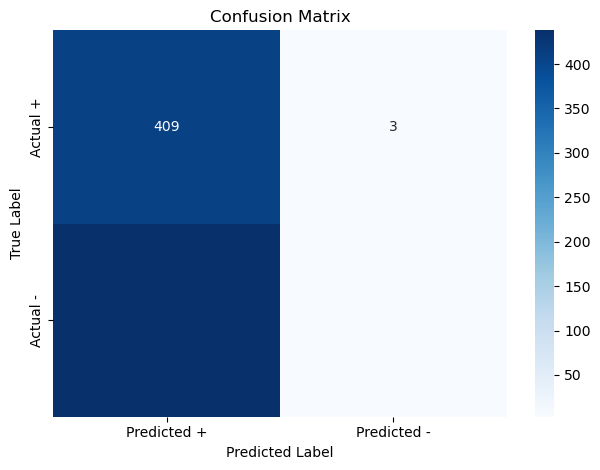

Classification Report:

                 precision    recall  f1-score   support

Positive Return       0.50      0.01      0.01       441
Negative Return       0.48      0.99      0.65       412

       accuracy                           0.48       853
      macro avg       0.49      0.50      0.33       853
   weighted avg       0.49      0.48      0.32       853



In [6]:
# --- Vector Autoregression (VAR) Modeling ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('Pfizer_Feature_Engineering_Master.csv', parse_dates=['Date'])

# Feature list
features = [
    'return_5d', 'return_20d', 'volatility_20d', 'rolling_mean_20d', 'rolling_std_20d',
    'zscore_price_20d', 'price_pct_change', 'volume_zscore_20d', 'rsi_14',
    'sentiment_score', 'rolling_sentiment_5d', 'sentiment_shift', 'sentiment_volatility_5d',
    'xlv_return_1d', 'xlv_return_5d', 'pfe_vs_xlv_spread', 'rolling_corr_pfe_xlv_20d',
    'lag_1_price', 'lag_2_price', 'lag_1_sentiment', 'lag_2_sentiment',
    'interaction_sentiment_non_neutral_return_5d', 'interaction_sentiment_volatility'
]
target = 'return_1d'

df_model = df[['Date', 'Modeling'] + features + [target]].dropna().copy()
train_data = df_model[df_model['Modeling'].isin(['Train', 'Validation'])].copy()
test_data = df_model[df_model['Modeling'] == 'Out-of-Sample'].copy()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_data[features])
X_test_scaled = scaler.transform(test_data[features])

# PCA
pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("Explained Variance Ratio by PCA components:")
print(pca.explained_variance_ratio_)

pc_cols = [f'PC{i+1}' for i in range(X_train_pca.shape[1])]
train_df = pd.DataFrame(X_train_pca, columns=pc_cols, index=train_data.index)
train_df[target] = train_data[target].values

test_df = pd.DataFrame(X_test_pca, columns=pc_cols, index=test_data.index)
test_df['Date'] = test_data['Date'].values
test_df[target] = test_data[target].values

# VAR
var_model = VAR(train_df)
results = var_model.fit(maxlags=5, ic='aic')
print(f"Selected VAR Lag Order: {results.k_ar}")

lag_order = results.k_ar
forecast_input = train_df[pc_cols + [target]].values[-lag_order:]
forecast = results.forecast(y=forecast_input, steps=len(test_df))
forecast_df = pd.DataFrame(forecast, columns=pc_cols + [target], index=test_df.index)
test_df['predicted_return_1d'] = forecast_df[target].values

test_df['Signal'] = np.where(test_df['predicted_return_1d'] >= 0, 1, -1)
test_df['Strategy_PnL'] = test_df['Signal'] * test_df[target]
test_df['Baseline_PnL'] = test_df[target]
test_df['Cumulative_Strategy_PnL'] = test_df['Strategy_PnL'].cumsum()
test_df['Cumulative_Baseline_PnL'] = test_df['Baseline_PnL'].cumsum()

rmse = np.sqrt(mean_squared_error(test_df[target], test_df['predicted_return_1d']))
print(f'RMSE of return_1d prediction: {rmse:.6f}')

# --- Visualizations ---

# 1. Cumulative PnL
plt.figure(figsize=(12, 6))
plt.plot(test_df['Date'], test_df['Cumulative_Strategy_PnL'], label='Strategy PnL')
plt.plot(test_df['Date'], test_df['Cumulative_Baseline_PnL'], label='Baseline PnL', linestyle='--')
plt.title('Cumulative PnL Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Daily returns histogram
plt.figure(figsize=(8, 5))
sns.histplot(test_df['Strategy_PnL'], bins=50, kde=True, color='blue')
plt.title('Daily Strategy PnL Distribution')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# 3. Trading signals
plt.figure(figsize=(12, 6))
colors = test_df['Signal'].map({1: 'green', -1: 'red'})
for i, (date, signal) in enumerate(zip(test_df['Date'], test_df['Signal'])):
    plt.vlines(date, 0, signal, color=colors.iloc[i], alpha=0.8)
    plt.plot(date, signal, 'o', color=colors.iloc[i])
plt.yticks([-1, 1], ['Short (-1)', 'Long (+1)'])
plt.title('Trading Signals Over Time')
plt.xlabel('Date')
plt.ylabel('Signal')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 4. Classification metrics
actual = np.where(test_df[target] >= 0, 1, -1)
predicted = test_df['Signal']
cm = confusion_matrix(actual, predicted, labels=[1, -1])
cr = classification_report(actual, predicted, target_names=['Positive Return', 'Negative Return'])

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted +', 'Predicted -'], yticklabels=['Actual +', 'Actual -'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print("Classification Report:\n")
print(cr)

Explained Variance Ratio by PCA components:
[0.20485547 0.1735136  0.1052493  0.0822968  0.06575339]

Using SARIMAX for univariate forecasting with exogenous PCA components.

                               SARIMAX Results                                
Dep. Variable:                 target   No. Observations:                 3025
Model:               SARIMAX(5, 0, 0)   Log Likelihood               11838.820
Date:                Sun, 01 Jun 2025   AIC                         -23655.639
Time:                        19:49:39   BIC                         -23589.478
Sample:                             0   HQIC                        -23631.851
                               - 3025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
PC1           -0.0036      0.000   

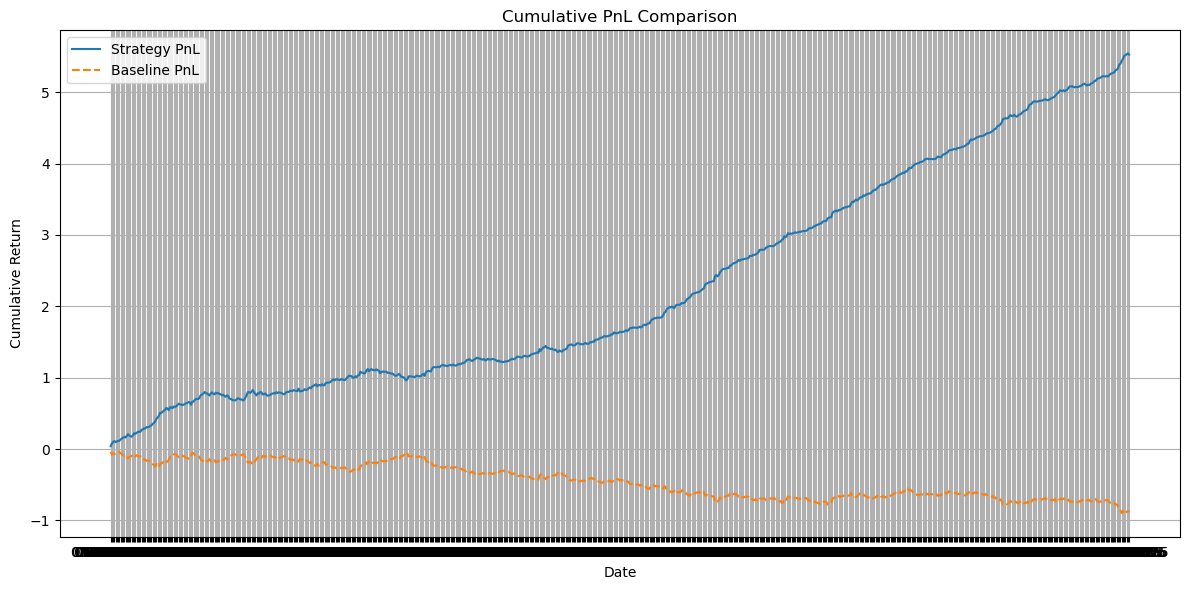

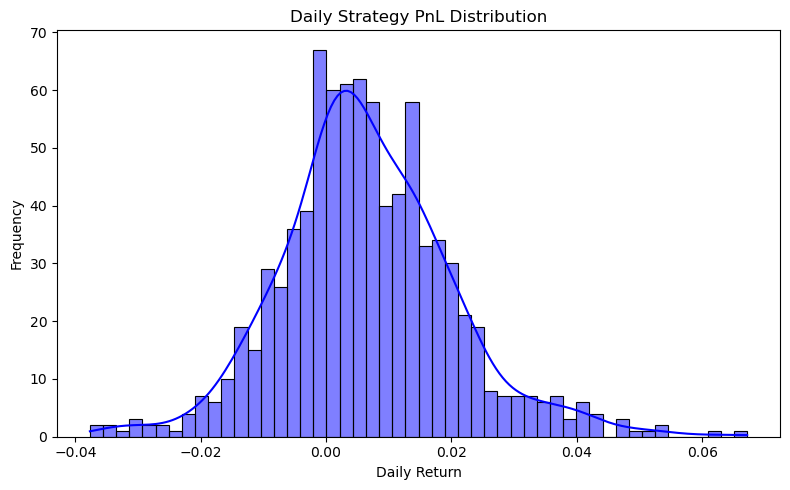

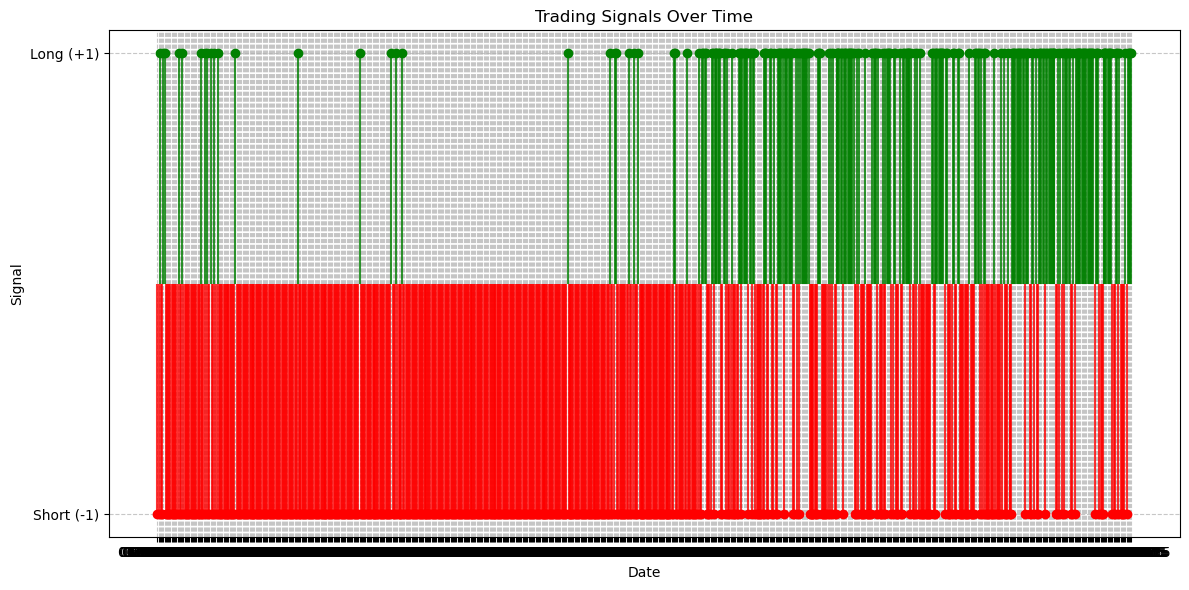

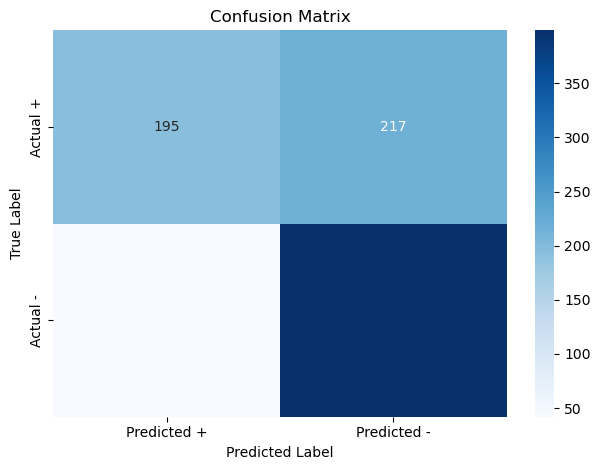

Classification Report:

                 precision    recall  f1-score   support

Positive Return       0.65      0.90      0.75       441
Negative Return       0.82      0.47      0.60       412

       accuracy                           0.70       853
      macro avg       0.74      0.69      0.68       853
   weighted avg       0.73      0.70      0.68       853



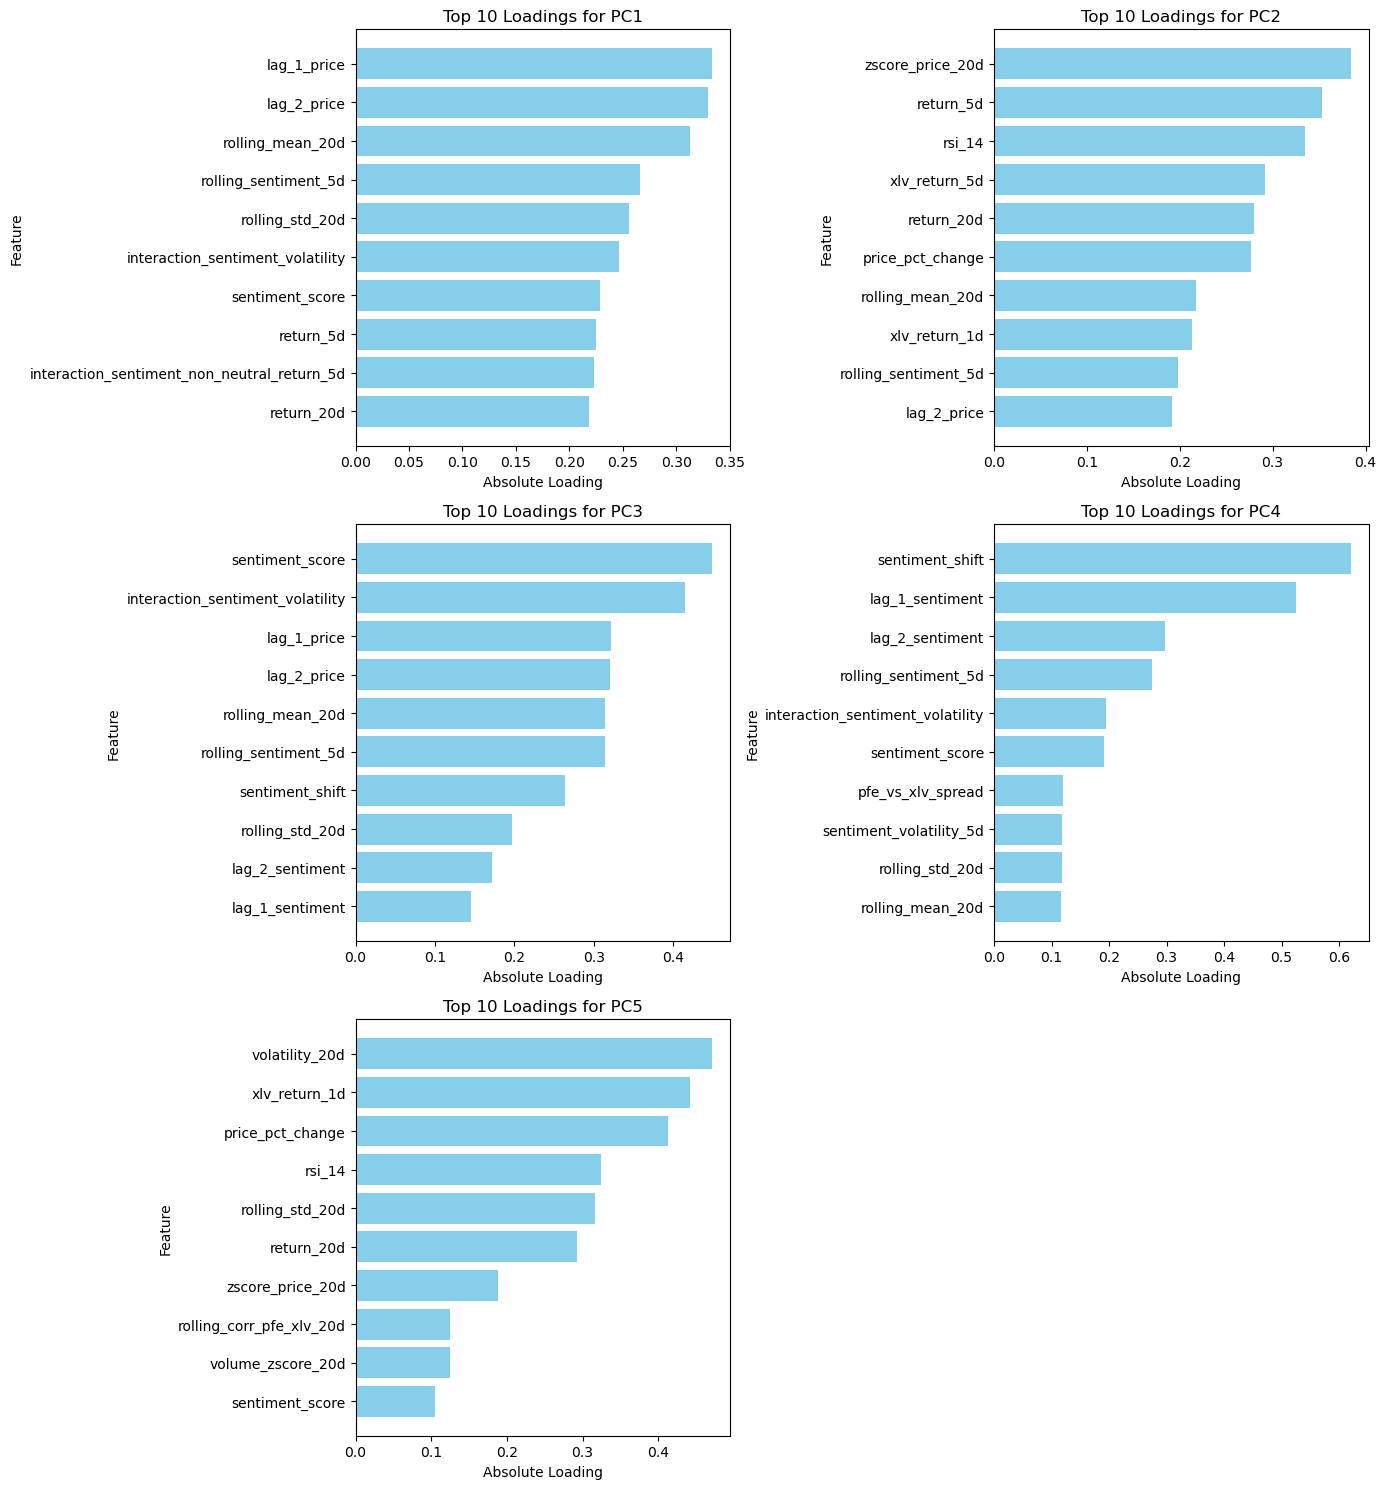

In [5]:
# --- Seasonal Autoregressive Integrated Moving Average with Exogenous Regressors (SARIMAX) Modeling ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('Pfizer_Feature_Engineering_Master.csv', parse_dates=['Date'])

# Feature list
features = [
    'return_5d', 'return_20d', 'volatility_20d', 'rolling_mean_20d', 'rolling_std_20d',
    'zscore_price_20d', 'price_pct_change', 'volume_zscore_20d', 'rsi_14',
    'sentiment_score', 'rolling_sentiment_5d', 'sentiment_shift', 'sentiment_volatility_5d',
    'xlv_return_1d', 'xlv_return_5d', 'pfe_vs_xlv_spread', 'rolling_corr_pfe_xlv_20d',
    'lag_1_price', 'lag_2_price', 'lag_1_sentiment', 'lag_2_sentiment',
    'interaction_sentiment_non_neutral_return_5d', 'interaction_sentiment_volatility'
]
target = 'return_1d'

df_model = df[['Date', 'Modeling'] + features + [target]].dropna().copy()
train_data = df_model[df_model['Modeling'].isin(['Train', 'Validation'])].copy()
test_data = df_model[df_model['Modeling'] == 'Out-of-Sample'].copy()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_data[features])
X_test_scaled = scaler.transform(test_data[features])

# PCA
pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
loadings = pd.DataFrame(pca.components_.T, index=features, columns=[f'PC{i+1}' for i in range(pca.n_components_)])

print("Explained Variance Ratio by PCA components:")
print(pca.explained_variance_ratio_)
print("\nUsing SARIMAX for univariate forecasting with exogenous PCA components.\n")

pc_cols = [f'PC{i+1}' for i in range(X_train_pca.shape[1])]
train_df = pd.DataFrame(X_train_pca, columns=pc_cols, index=train_data.index)
train_df['target'] = train_data[target].values

test_df = pd.DataFrame(X_test_pca, columns=pc_cols, index=test_data.index)
test_df['Date'] = test_data['Date'].values
test_df['target'] = test_data[target].values

endog = train_df['target']
exog = train_df[pc_cols]

model = SARIMAX(endog=endog, exog=exog, order=(5, 0, 0))
results = model.fit(disp=False)
print(results.summary())

forecast = results.get_forecast(steps=len(test_df), exog=test_df[pc_cols])
test_df['predicted_return_1d'] = forecast.predicted_mean.values

test_df['Signal'] = np.where(test_df['predicted_return_1d'] >= 0, 1, -1)
test_df['Strategy_PnL'] = test_df['Signal'] * test_df['target']
test_df['Baseline_PnL'] = test_df['target']
test_df['Cumulative_Strategy_PnL'] = test_df['Strategy_PnL'].cumsum()
test_df['Cumulative_Baseline_PnL'] = test_df['Baseline_PnL'].cumsum()

# RMSE
rmse = np.sqrt(mean_squared_error(test_df['target'], test_df['predicted_return_1d']))
print(f'RMSE of return_1d prediction: {rmse:.6f}')

# --- Visualizations ---

# 1. Cumulative PnL
plt.figure(figsize=(12, 6))
plt.plot(test_df['Date'], test_df['Cumulative_Strategy_PnL'], label='Strategy PnL')
plt.plot(test_df['Date'], test_df['Cumulative_Baseline_PnL'], label='Baseline PnL', linestyle='--')
plt.title('Cumulative PnL Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Daily returns histogram
plt.figure(figsize=(8, 5))
sns.histplot(test_df['Strategy_PnL'], bins=50, kde=True, color='blue')
plt.title('Daily Strategy PnL Distribution')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# 3. Trading signals
plt.figure(figsize=(12, 6))
colors = test_df['Signal'].map({1: 'green', -1: 'red'})
for i, (date, signal) in enumerate(zip(test_df['Date'], test_df['Signal'])):
    plt.vlines(date, 0, signal, color=colors.iloc[i], alpha=0.8)
    plt.plot(date, signal, 'o', color=colors.iloc[i])
plt.yticks([-1, 1], ['Short (-1)', 'Long (+1)'])
plt.title('Trading Signals Over Time')
plt.xlabel('Date')
plt.ylabel('Signal')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 4. Classification metrics
actual = np.where(test_df['target'] >= 0, 1, -1)
predicted = test_df['Signal']
cm = confusion_matrix(actual, predicted, labels=[1, -1])
cr = classification_report(actual, predicted, target_names=['Positive Return', 'Negative Return'])

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted +', 'Predicted -'],
            yticklabels=['Actual +', 'Actual -'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print("Classification Report:\n")
print(cr)

# 5. Feature Importance
top_n = 10
num_pcs = loadings.shape[1]

cols = 2
rows = int(np.ceil(num_pcs / cols))
fig, axes = plt.subplots(rows, cols, figsize=(14, 5 * rows))
axes = axes.flatten()

for i in range(num_pcs):
    pc = loadings.columns[i]
    sorted_loadings = loadings[pc].abs().sort_values(ascending=False).head(top_n)
    axes[i].barh(sorted_loadings.index[::-1], sorted_loadings.values[::-1], color='skyblue')
    axes[i].set_title(f'Top {top_n} Loadings for {pc}')
    axes[i].set_xlabel('Absolute Loading')
    axes[i].set_ylabel('Feature')

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Buy/Sell Signal Accuracy: 0.9812

Classification Report:
               precision    recall  f1-score   support

          -1       1.00      0.97      0.98       475
           1       0.96      1.00      0.98       378

    accuracy                           0.98       853
   macro avg       0.98      0.98      0.98       853
weighted avg       0.98      0.98      0.98       853



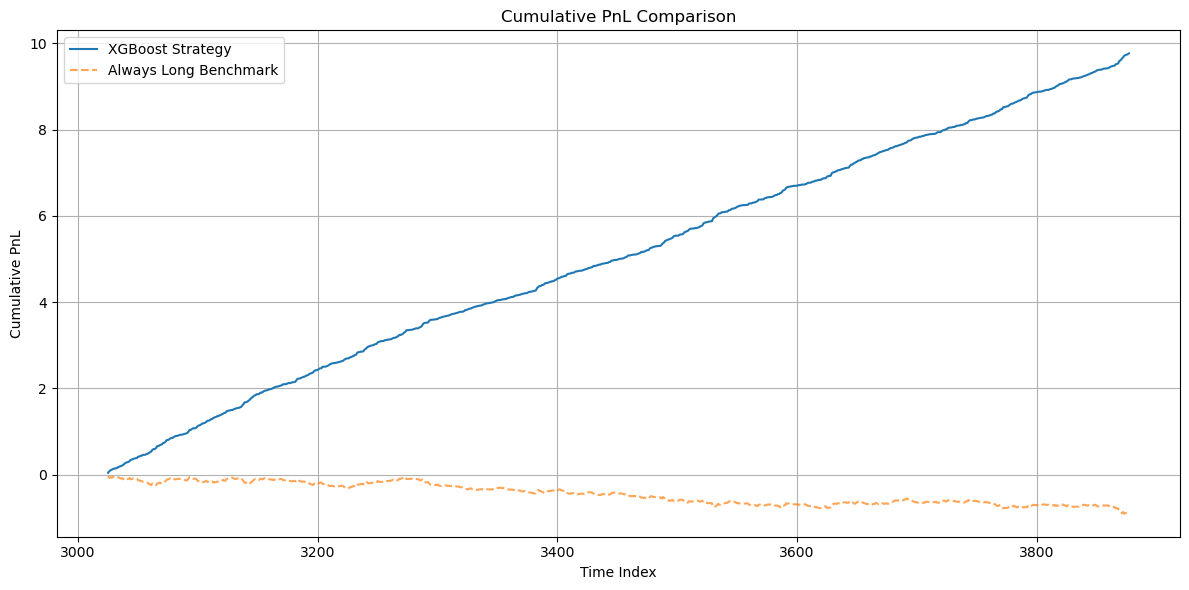

C:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


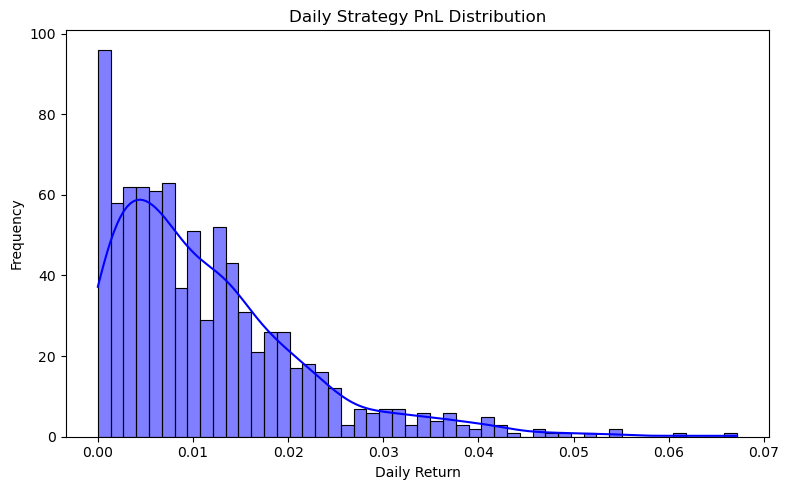

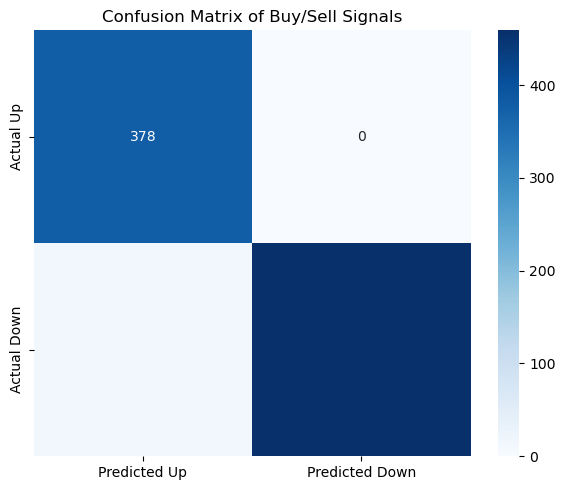

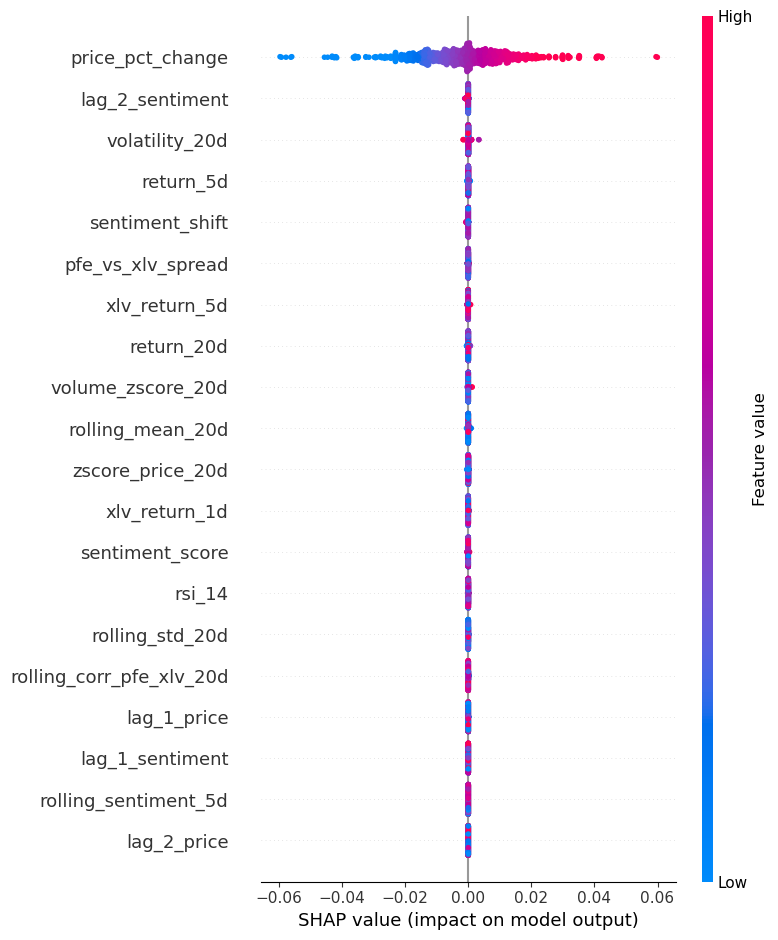

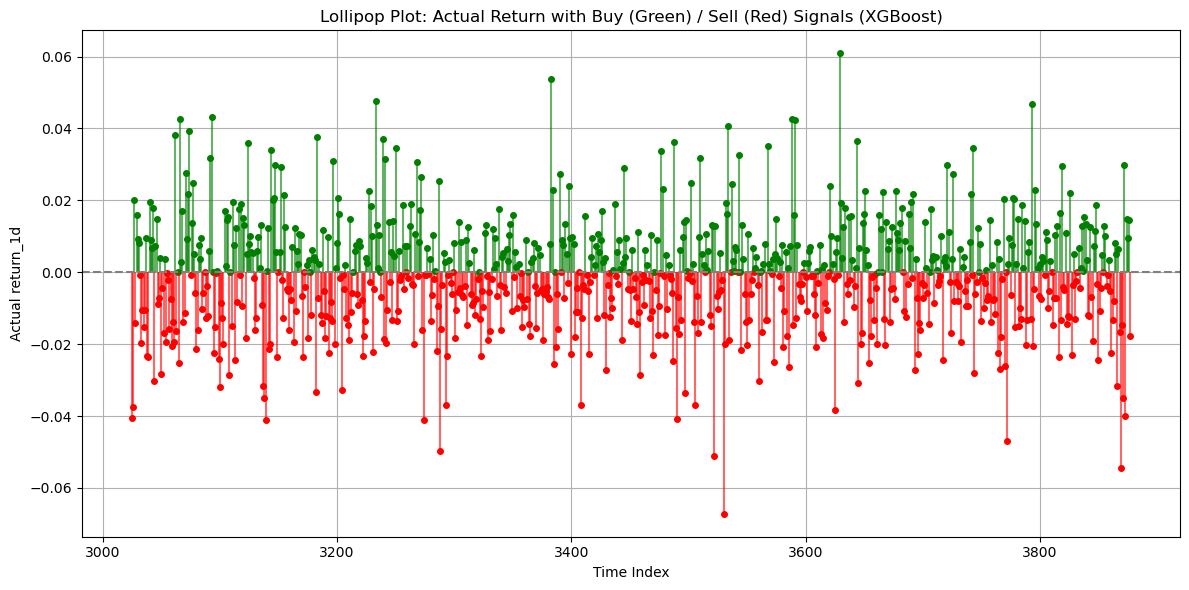

In [4]:
# --- eXtreme Gradient Boosting (XGBoost) Modeling ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder

df = pd.read_csv('Pfizer_Feature_Engineering_Master.csv')

le = LabelEncoder()
df['sentiment_label'] = le.fit_transform(df['sentiment_label'])

# Feature list
features = ['return_5d', 'return_20d', 'volatility_20d', 'rolling_mean_20d', 'rolling_std_20d',
            'zscore_price_20d', 'price_pct_change', 'volume_zscore_20d', 'rsi_14', 'sentiment_score',
            'sentiment_label', 'rolling_sentiment_5d', 'sentiment_shift', 'sentiment_volatility_5d',
            'xlv_return_1d', 'xlv_return_5d', 'pfe_vs_xlv_spread', 'rolling_corr_pfe_xlv_20d',
            'lag_1_price', 'lag_2_price', 'lag_1_sentiment', 'lag_2_sentiment']
target = 'return_1d'

train_val = df[df['Modeling'].isin(['Train', 'Validation'])].copy()
test = df[df['Modeling'] == 'Out-of-Sample'].copy()

train = train_val[train_val['Modeling'] == 'Train']
val = train_val[train_val['Modeling'] == 'Validation']

scaler = StandardScaler()
X_train = scaler.fit_transform(train[features])
X_val = scaler.transform(val[features])
X_test = scaler.transform(test[features])

y_train, y_val, y_test = train[target], val[target], test[target]

model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, 
                     random_state=42, early_stopping_rounds=10)
model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

test = test.copy()
test['pred_return_1d'] = model.predict(X_test)
test['signal'] = np.where(test['pred_return_1d'] > 0, 1, -1)
test['pnl'] = test['signal'] * test['return_1d']
test['pnl_baseline'] = test['return_1d']
test['cum_pnl'] = test['pnl'].cumsum()
test['cum_pnl_baseline'] = test['pnl_baseline'].cumsum()

# Classification Performance
test['actual_direction'] = np.where(test['return_1d'] > 0, 1, -1)
accuracy = accuracy_score(test['actual_direction'], test['signal'])
print(f"\nBuy/Sell Signal Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(test['actual_direction'], test['signal']))

# --- Visualizations ---

# 1. Cumulative PnL Curve
plt.figure(figsize=(12, 6))
plt.plot(test['cum_pnl'], label='XGBoost Strategy')
plt.plot(test['cum_pnl_baseline'], label='Always Long Benchmark', linestyle='--', alpha=0.7)
plt.title('Cumulative PnL Comparison')
plt.xlabel('Time Index')
plt.ylabel('Cumulative PnL')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Histogram of Daily Returns
plt.figure(figsize=(8, 5))
sns.histplot(test['pnl'], bins=50, kde=True, color='blue')
plt.title('Daily Strategy PnL Distribution')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# 3. Confusion Matrix
cm = confusion_matrix(test['actual_direction'], test['signal'], labels=[1, -1])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Up', 'Predicted Down'], 
            yticklabels=['Actual Up', 'Actual Down'])
plt.title('Confusion Matrix of Buy/Sell Signals')
plt.tight_layout()
plt.show()

# 4. Feature Importance
import shap
explainer = shap.Explainer(model)
shap_values = explainer(X_test)
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, features=test[features], feature_names=features, show=True)

# 5. Signal Overlay (Lollipop Plot)
plt.figure(figsize=(12, 6))
colors = test['signal'].map({1: 'green', -1: 'red'})
for i in range(len(test)):
    plt.vlines(x=test.index[i], ymin=0, ymax=test['return_1d'].iloc[i], color=colors.iloc[i], alpha=0.6)
    plt.plot(test.index[i], test['return_1d'].iloc[i], 'o', color=colors.iloc[i], markersize=4)

plt.axhline(0, color='gray', linestyle='--')
plt.title('Lollipop Plot: Actual Return with Buy (Green) / Sell (Red) Signals (XGBoost)')
plt.xlabel('Time Index')
plt.ylabel('Actual return_1d')
plt.grid(True)
plt.tight_layout()
plt.show()